# Data Engineering:
# ■ Techniques: ETL (Extract, Transform, Load) pipelines, workflow automation.
# ■ Libraries: Apache Airflow, Prefect.
# ■ Project: Build a pipeline to scrape, clean, and store data.

In [7]:
import os
import pandas as pd
from datetime import datetime, timedelta
from binance.client import Client

API_KEY = "tEHGYJwF3QhigT7T88kM4Lj2kzpsgdCmTQTxueX4skDec0KkPAG59UPdQFvK2hcy"
API_SECRET = "Mm8IX5vPJ26I3y3LV0qbNvUXr3JBW3DpT6MBShzrJZDB5Ee4G30SJRT74x53wwYF"
client = Client(API_KEY, API_SECRET)

# Define parameters
TOP_10_CURRENCIES = ["BTCUSDT", "ETHUSDT", "BNBUSDT", "XRPUSDT", "ADAUSDT",
                     "DOGEUSDT", "SOLUSDT", "MATICUSDT", "DOTUSDT", "LTCUSDT"]
INTERVAL = Client.KLINE_INTERVAL_1HOUR  # 1-hour interval
DAYS_BACK = 730  # 2 years


def get_market_prices(symbol):
    """Fetches the current market price"""
    ticker = client.get_symbol_ticker(symbol=symbol)
    df = pd.DataFrame([ticker])
    df['timestamp'] = datetime.now()
    df['data_type'] = "market_price"
    return df[['data_type', 'symbol', 'price', 'timestamp']]


def get_order_book(symbol, depth=5):
    """Fetches order book data"""
    order_book = client.get_order_book(symbol=symbol, limit=depth)
    bids = pd.DataFrame(order_book['bids'], columns=['price', 'quantity'])
    asks = pd.DataFrame(order_book['asks'], columns=['price', 'quantity'])
    bids['type'] = 'bid'
    asks['type'] = 'ask'

    df = pd.concat([bids, asks])
    df['symbol'] = symbol
    df['timestamp'] = datetime.now()
    df['data_type'] = "order_book"
    return df[['data_type', 'symbol', 'price', 'quantity', 'type', 'timestamp']]


def get_recent_trades(symbol):
    """Fetches recent trades data"""
    trades = client.get_recent_trades(symbol=symbol)
    df = pd.DataFrame(trades)

    if df.empty:
        return pd.DataFrame()  # Return empty DataFrame if no data

    df['timestamp'] = pd.to_datetime(df['time'], unit='ms')
    df['data_type'] = "recent_trades"
    df.rename(columns={'qty': 'quantity', 'id': 'tradeId'}, inplace=True)

    required_columns = ['data_type', 'price', 'quantity', 'timestamp', 'tradeId']
    return df[[col for col in required_columns if col in df.columns]]


def get_candlestick_data(symbol):
    """Fetches historical candlestick (OHLCV) data for the last 2 years"""
    end_time = datetime.now()
    start_time = end_time - timedelta(days=DAYS_BACK)

    klines = client.get_historical_klines(symbol, INTERVAL, start_time.strftime("%d %b %Y"), end_time.strftime("%d %b %Y"))
    
    df = pd.DataFrame(klines, columns=['timestamp', 'open', 'high', 'low', 'close', 'volume', 'close_time',
                                       'quote_asset_volume', 'num_trades', 'taker_buy_base_asset_volume',
                                       'taker_buy_quote_asset_volume', 'ignore'])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='ms')
    df['data_type'] = "candlestick_data"
    
    return df[['data_type', 'timestamp', 'open', 'high', 'low', 'close', 'volume', 'num_trades']]


# Fetch all data for the top 10 cryptocurrencies
data = []

for symbol in TOP_10_CURRENCIES:
    print(f"Fetching data for {symbol}...")

    # Collect different datasets
    data.append(get_market_prices(symbol))
    data.append(get_order_book(symbol))
    data.append(get_recent_trades(symbol))
    data.append(get_candlestick_data(symbol))

# Combine all data into one DataFrame, handling missing columns
final_df = pd.concat([df for df in data if not df.empty], ignore_index=True)

# Fill missing values to avoid data loss
final_df.fillna(method="ffill", inplace=True)

# Save to CSV
final_df.to_csv("binance_top10_data.csv", index=False)
print("Data saved to binance_top10_data.csv ✅")


Fetching data for BTCUSDT...
Fetching data for ETHUSDT...
Fetching data for BNBUSDT...
Fetching data for XRPUSDT...
Fetching data for ADAUSDT...
Fetching data for DOGEUSDT...
Fetching data for SOLUSDT...
Fetching data for MATICUSDT...
Fetching data for DOTUSDT...
Fetching data for LTCUSDT...


C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_8576\3456876318.py:89: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  final_df.fillna(method="ffill", inplace=True)


Data saved to binance_top10_data.csv ✅


In [8]:
final_df

,data_type,symbol,price,timestamp,quantity,type,tradeId,open,high,low,close,volume,num_trades
0,market_price,BTCUSDT,90199.81000000,2025-03-06 06:10:32.100833,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,order_book,BTCUSDT,90199.81000000,2025-03-06 06:10:32.420125,0.07786000,bid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,order_book,BTCUSDT,90199.80000000,2025-03-06 06:10:32.420125,0.00012000,bid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,order_book,BTCUSDT,90199.79000000,2025-03-06 06:10:32.420125,0.00039000,bid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,order_book,BTCUSDT,90199.78000000,2025-03-06 06:10:32.420125,0.00068000,bid,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
176049,candlestick_data,LTCUSDT,104.04000000,2025-03-05 20:00:00.000000,0.05000000,ask,432036977.0,104.02000000,105.18000000,103.81000000,104.84000000,26089.24400000,18602.0
176050,candlestick_data,LTCUSDT,104.04000000,2025-03-05 21:00:00.000000,0.05000000,ask,432036977.0,104.85000000,105.34000000,104.21000000,105.07000000,30595.13800000,18684.0
176051,candlestick_data,LTCUSDT,104.04000000,2025-03-05 22:00:00.000000,0.05000000,ask,432036977.0,105.06000000,105.24000000,104.52000000,104.96000000,17812.86100000,14529.0
176052,candlestick_data,LTCUSDT,104.04000000,2025-03-05 23:00:00.000000,0.05000000,ask,432036977.0,104.96000000,105.22000000,104.51000000,104.73000000,28868.43500000,19308.0


# Load and Inspect Data

In [8]:
import pandas as pd
import numpy as np

# Load dataset
df = pd.read_csv("binance_top10_data.csv")

# Strip spaces from column names to avoid errors
df.columns = df.columns.str.strip()

# Display basic info
print("Dataset Info:")
print(df.info())

# Display missing values count
print("\nMissing Values Before Cleaning:")
print(df.isna().sum())


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176054 entries, 0 to 176053
Data columns (total 13 columns):
 #   Column      Non-Null Count   Dtype  
---  ------      --------------   -----  
 0   data_type   176054 non-null  object 
 1   symbol      176054 non-null  object 
 2   price       176054 non-null  float64
 3   timestamp   176054 non-null  object 
 4   quantity    176053 non-null  float64
 5   type        176053 non-null  object 
 6   tradeId     176043 non-null  float64
 7   open        175543 non-null  float64
 8   high        175543 non-null  float64
 9   low         175543 non-null  float64
 10  close       175543 non-null  float64
 11  volume      175543 non-null  float64
 12  num_trades  175543 non-null  float64
dtypes: float64(9), object(4)
memory usage: 17.5+ MB
None

Missing Values Before Cleaning:
data_type       0
symbol          0
price           0
timestamp       0
quantity        1
type            1
tradeId        11
open          511
high      

#  Convert Timestamp Column to Datetime

In [9]:
# Convert 'timestamp' column to datetime format
df['timestamp'] = pd.to_datetime(df['timestamp'].astype(str).str.strip(), errors='coerce')

# Handle missing timestamps by forward-filling
df['timestamp'].fillna(method='ffill', inplace=True)

print("\nMissing Timestamps After Forward Fill:", df['timestamp'].isna().sum())



Missing Timestamps After Forward Fill: 0


C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_11012\2600003760.py:5: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['timestamp'].fillna(method='ffill', inplace=True)
C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_11012\2600003760.py:5: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df['timestamp'].fillna(method='ffill', inplace=True)


# Identify Numeric & Categorical Columns

In [10]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns
print("\nNumeric Columns:", numeric_cols)

# Identify categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns
print("\nCategorical Columns:", categorical_cols)



Numeric Columns: Index(['price', 'quantity', 'tradeId', 'open', 'high', 'low', 'close',
       'volume', 'num_trades'],
      dtype='object')

Categorical Columns: Index(['data_type', 'symbol', 'type'], dtype='object')


# Handle Missing Values in Numeric Columns using KNN Imputation

In [11]:
from sklearn.impute import KNNImputer

# Initialize KNN Imputer with 5 nearest neighbors
knn_imputer = KNNImputer(n_neighbors=5)

# Apply imputation on numeric columns
df[numeric_cols] = knn_imputer.fit_transform(df[numeric_cols])

# Check missing values after KNN Imputation
print("\nMissing Values After KNN Imputation:\n", df[numeric_cols].isna().sum())



Missing Values After KNN Imputation:
 price         0
quantity      0
tradeId       0
open          0
high          0
low           0
close         0
volume        0
num_trades    0
dtype: int64


# Handle Missing Values in Categorical Columns

In [12]:
# Fill missing categorical values using the most frequent value (mode)
for col in categorical_cols:
    df[col].fillna(df[col].mode()[0], inplace=True)

# Verify missing values after categorical imputation
print("\nMissing Values After Categorical Mode Imputation:\n", df[categorical_cols].isna().sum())



Missing Values After Categorical Mode Imputation:
 data_type    0
symbol       0
type         0
dtype: int64


C:\Users\Hassan Laptop Point\AppData\Local\Temp\ipykernel_11012\2176402146.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].mode()[0], inplace=True)


# Verify Final Cleaned Data & Save

In [13]:
# Final missing values check
print("\nFinal Missing Values Count:\n", df.isna().sum())

# Save cleaned dataset
df.to_csv("binance_top10_cleaned_ml.csv", index=False)

print("\n✅ Cleaned Data Saved Successfully!")



Final Missing Values Count:
 data_type     0
symbol        0
price         0
timestamp     0
quantity      0
type          0
tradeId       0
open          0
high          0
low           0
close         0
volume        0
num_trades    0
dtype: int64

✅ Cleaned Data Saved Successfully!


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns


# Load Data and Check Missing Values Visually

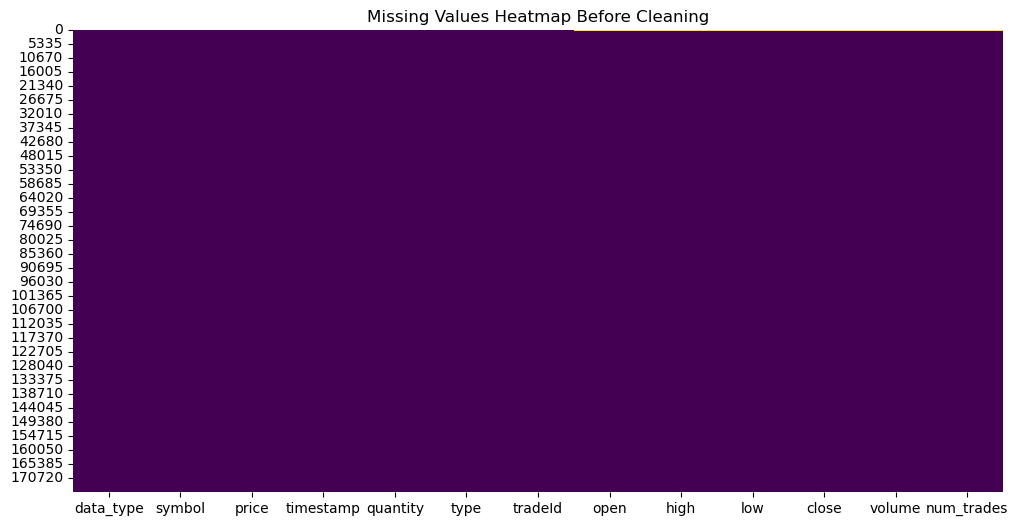

In [15]:
# Load dataset
df = pd.read_csv("binance_top10_data.csv")

# Strip spaces from column names
df.columns = df.columns.str.strip()

# Visualizing missing values using a heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis')
plt.title("Missing Values Heatmap Before Cleaning")
plt.show()


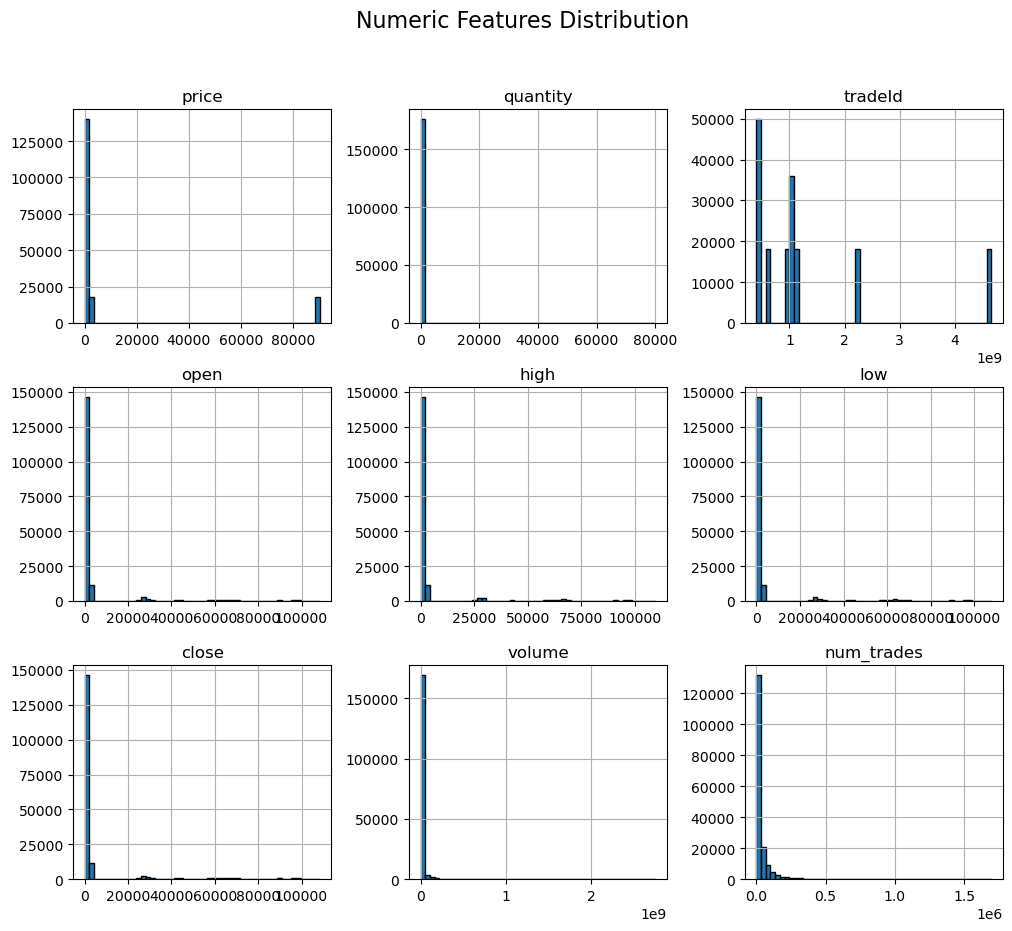

In [16]:
# Identify numeric columns
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Plot distribution for numeric features
df[numeric_cols].hist(figsize=(12, 10), bins=50, edgecolor="black")
plt.suptitle("Numeric Features Distribution", fontsize=16)
plt.show()


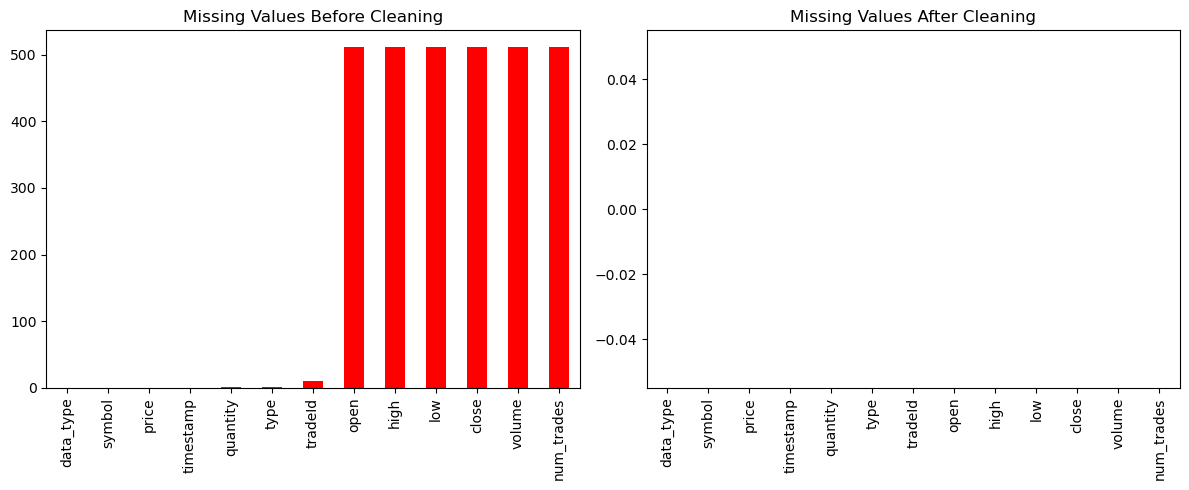

In [17]:
# Load cleaned dataset
df_cleaned = pd.read_csv("binance_top10_cleaned_ml.csv")

# Side-by-side missing value count comparison
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df.isnull().sum().plot(kind='bar', color='red')
plt.title("Missing Values Before Cleaning")
plt.xticks(rotation=90)

plt.subplot(1, 2, 2)
df_cleaned.isnull().sum().plot(kind='bar', color='green')
plt.title("Missing Values After Cleaning")
plt.xticks(rotation=90)

plt.tight_layout()
plt.show()


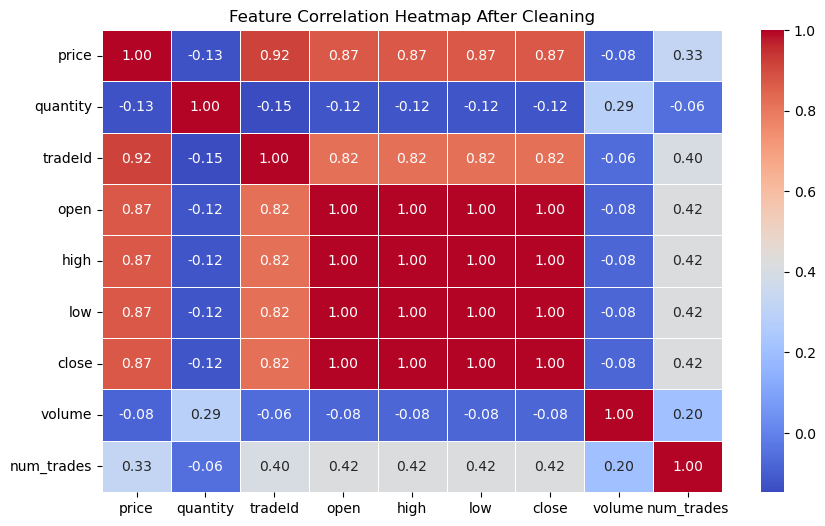

In [18]:
numeric_df = df.select_dtypes(include=['number'])

plt.figure(figsize=(10, 6))
sns.heatmap(numeric_df.corr(), annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap After Cleaning")
plt.show()


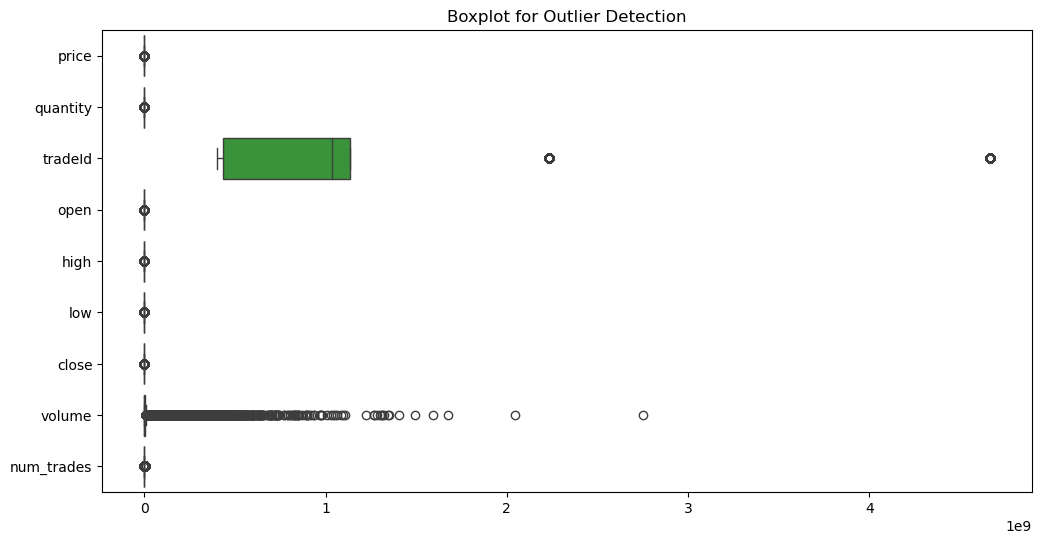

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=df_cleaned[numeric_cols], orient="h")
plt.title("Boxplot for Outlier Detection")
plt.show()


## Saving Data in MySQL

In [6]:
pip install mysql-connector-python pandas


   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.1 MB ? eta -:--:--
   ---------------------------------------- 0.0/16.1 MB 445.2 kB/s eta 0:00:37
   ---------------------------------------- 0.1/16.1 MB 491.5 kB/s eta 0:00:33
   ---------------------------------------- 0.1/16.1 MB 655.4 kB/s eta 0:00:25
   ---------------------------------------- 0.1/16.1 MB 655.4 kB/s eta 0:00:25
    --------------------------------------- 0.2/16.1 MB 734.2 kB/s eta 0:00:22
    --------------------------------------- 0.2/16.1 MB 811.5 kB/s eta 0:00:20
    --------------------------------------- 0.3/16.1 MB 941.3 kB/s eta 0:00:17
   - -------------------------------------- 0.4/16.1 MB 1.0 MB/s eta 0:00:16
   - -------------------------------------- 0.6/16.1 MB 1.2 MB/s eta 0:00:13
   - -------------------------------------- 0.6/16.1 MB 1.2 MB/s eta 0:00:13
   - -------------------------------------- 0.7/16.1 MB 1.3 MB/s eta 0:00:13